# 機動戦士ガンダム』で学ぶ宇宙世紀の物理学 ――君は生き延びることができるか?

## 実行用

In [1]:
import numpy as np; import math
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.patches as patches

In [2]:
# matplotlibの日本語処理用
#plt.rcParams['font.family']='Hiragino Sans'# フォント設定
#plt.rcParams['font.weight']='bold' # 太さ
plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"]=15,15

In [3]:
# 地球と月に関する物理数値
G = 6.67430e-11  # 万有引力定数 [m^3/kg/s^2]
M1 = 5.972e24  # 天体1（地球）の質量 [kg]
M2 = 7.342e22  # 天体2（月）の質量 [kg]
D = 3.844e8  # 地球-月の距離 [m]
# 地球と月の共通重心位置を原点とする
r1 = -M2*D/(M1+M2)  # 地球の位置 [m]
r2 = M1*D/(M1+M2)   # 月の位置 [m]
omega = np.sqrt(G*(M1+M2)/D**3)  # 地球と月の回転角速度 [rad/s]
# ラグランジュポイントの位置
Ls=[[r2-D*(M2/(3*M1))**(1/3),0],[r2+D*(M2/(3*M1))**(1/3),0],
    [r1-D*(M2/(3*M1))**(1/3),0],[D/2,np.sqrt(3)*D/2],[D/2,-np.sqrt(3)*D/2]]

def gravity(x, y): # 重力(重力加速度)の計算
    r1_vec = np.array([r1, 0]) # 天体1位置ベクトル
    r2_vec = np.array([r2, 0]) # 天体2位置ベクトル
    r_obj  = np.array([x, y])  # 物体位置ベクトル
    r_1 = r_obj-r1_vec # 天体1⇒物体ベクトル
    r_2 = r_obj-r2_vec # 天体2⇒物体ベクトル
    g_1 = -G*M1*r_1/np.linalg.norm(r_1)**3
    g_2 = -G*M2*r_2/np.linalg.norm(r_2)**3
    return g_1+g_2 # 天体1と天体2からの重力を合算して返す

def equations(t, state):  # 運動方程式
    x, y, vx, vy = state
    gx,gy= gravity(x, y)           # 重力
    cx,cy= omega**2*np.array([x,y]) # 遠心力
    fx,fy= -2*omega*np.array([-vy,vx]) # コリオリ力
    return [vx, vy, gx+cx+fx, gy+cy+fy]

def do_simulation(state0,t_span, n=1000): # 刻々の計算を行う
    t_eval = np.linspace(0, t_span[1], n)
    return solve_ivp(equations, t_span, state0, 
                t_eval=t_eval, rtol=1e-9, atol=1e-9)
    
def visualize_2d(sols,is_plot_day=False): # 2次元表示
    plt.figure(figsize=(16, 16))
    plt.scatter([L[0] for L in Ls],[L[1] for L in Ls],c='r',
                marker='x',s=500,label="ラグランジュ・ポイント")
    plt.scatter(r1,0,c='blue',s=1500,label="地球")
    plt.scatter(r2,0,c='gray',s=500,label="月")
    for sol in sols:
        plt.plot(sol["sol"].y[0], sol["sol"].y[1],label=sol["name"],zorder=0)
        if is_plot_day:
            last_t=0; day=1
            for i in range(len(sol["sol"].t)-1):
                if (sol["sol"].t[i]-last_t)>24*60*60:  # 1日ごとにマーカー
                    plt.text(sol["sol"].y[0, i], sol["sol"].y[1, i],
                        f"{day}d", fontsize=26, color='black')
                    plt.scatter(sol["sol"].y[0,i],sol["sol"].y[1,i],c='black',s=200)
                    last_t=sol["sol"].t[i]; day+=1
    plt.xlabel("x [m]"); plt.ylabel("y [m]"); plt.title("地球と月周りの回転座標系")
    plt.gca().set_aspect('equal',adjustable='box');plt.legend();plt.grid();plt.show()

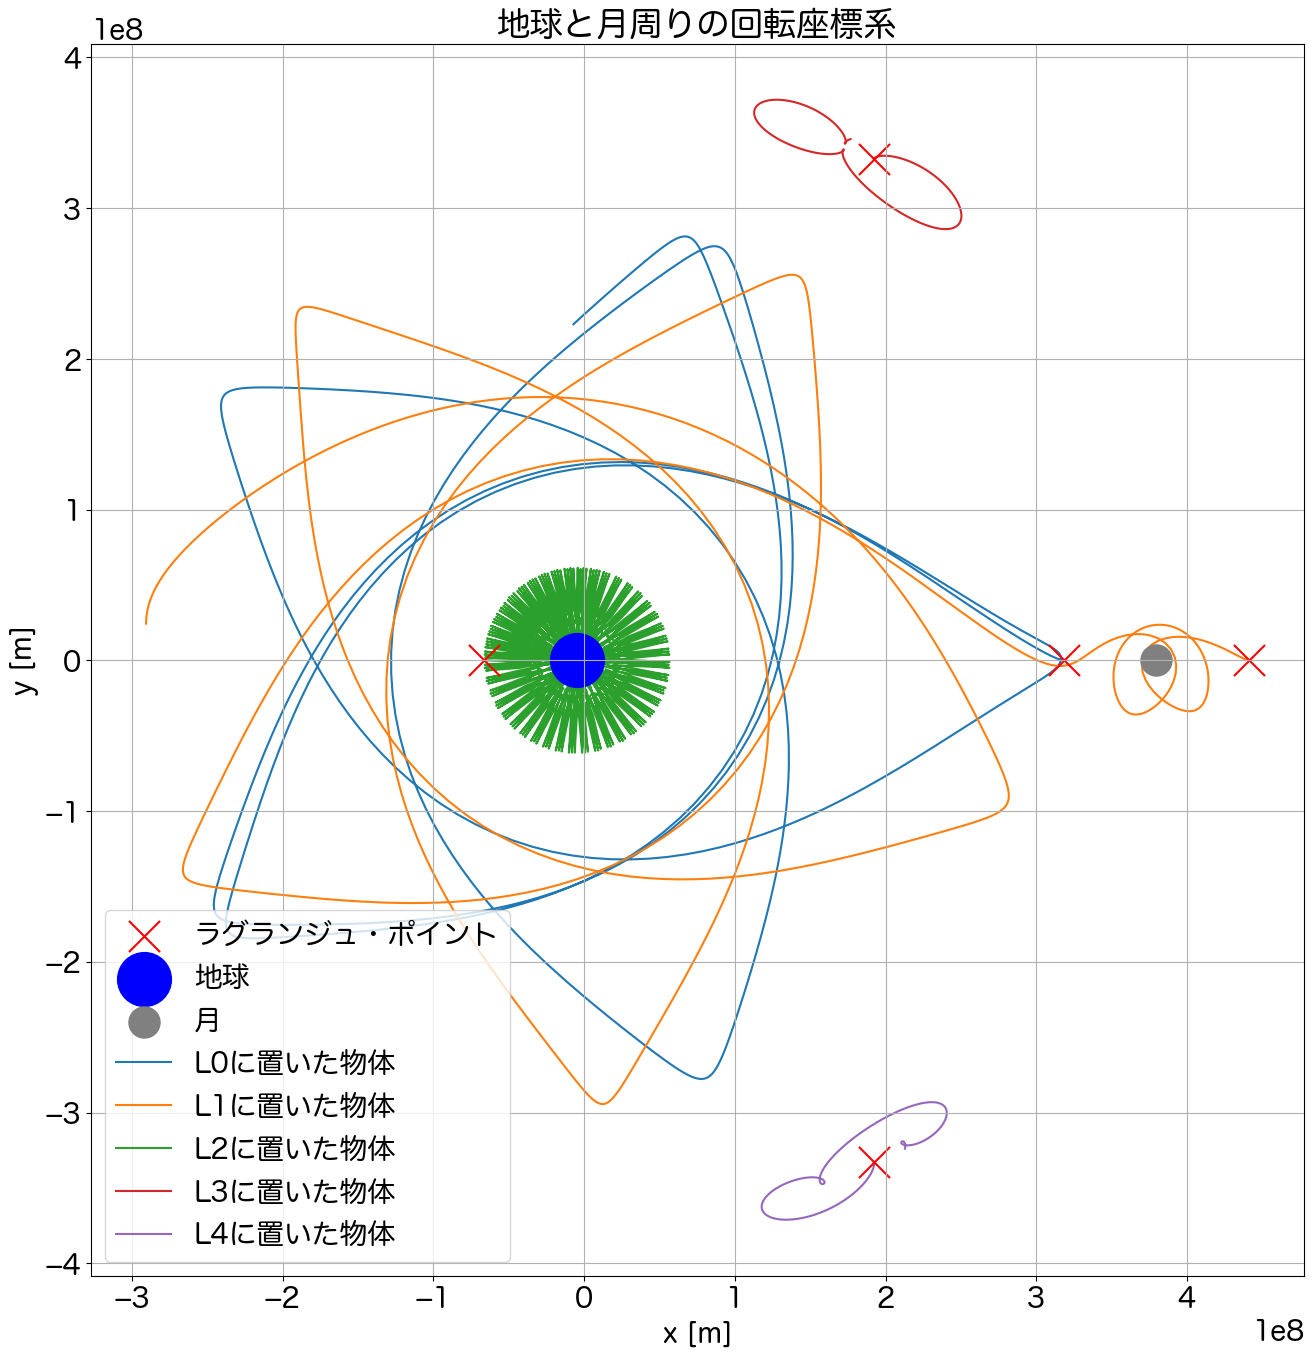

In [4]:
conditions=[{"pv":[Ls[i][0],Ls[i][1],0,0],"t":(0,90*24*3600),"name":f"L{i}に置いた物体"} \
            for i in range(5)]
sols = [ {"sol":do_simulation(c["pv"],c["t"]),"name":c["name"]} for c in conditions ]
visualize_2d(sols)

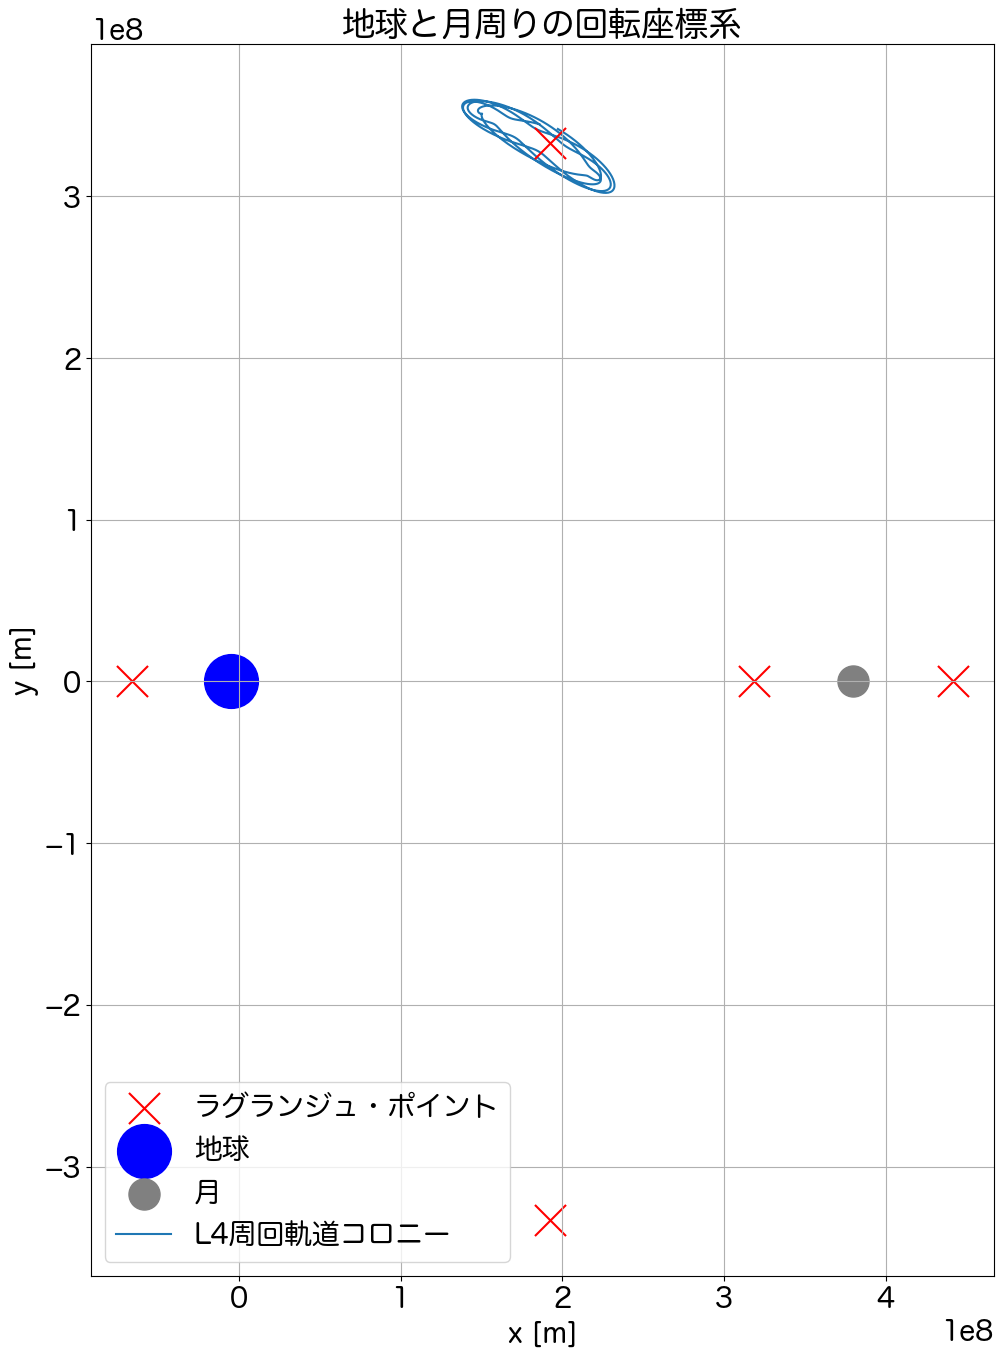

In [5]:
x0_init=0; y0_init=10000*1000
vx0= (y0_init*2*omega)*(math.sqrt(3)/2)+(-x0_init/2*omega)*1/2 
vy0= (y0_init*2*omega)*(-1/2)+(-x0_init/2*omega)*(math.sqrt(3)/2)
x0 = y0_init*1/2; y0 = y0_init*math.sqrt(3)/2
conditions=[ {"pv":[Ls[3][0]+x0,Ls[3][1]+y0, vx0, vy0], 
              "t":(0, 365 * 24 * 3600),"name":"L4周回軌道コロニー"}]
sols = [{"sol":do_simulation(c["pv"],c["t"]),"name":c["name"]} for c in conditions ]
visualize_2d(sols)

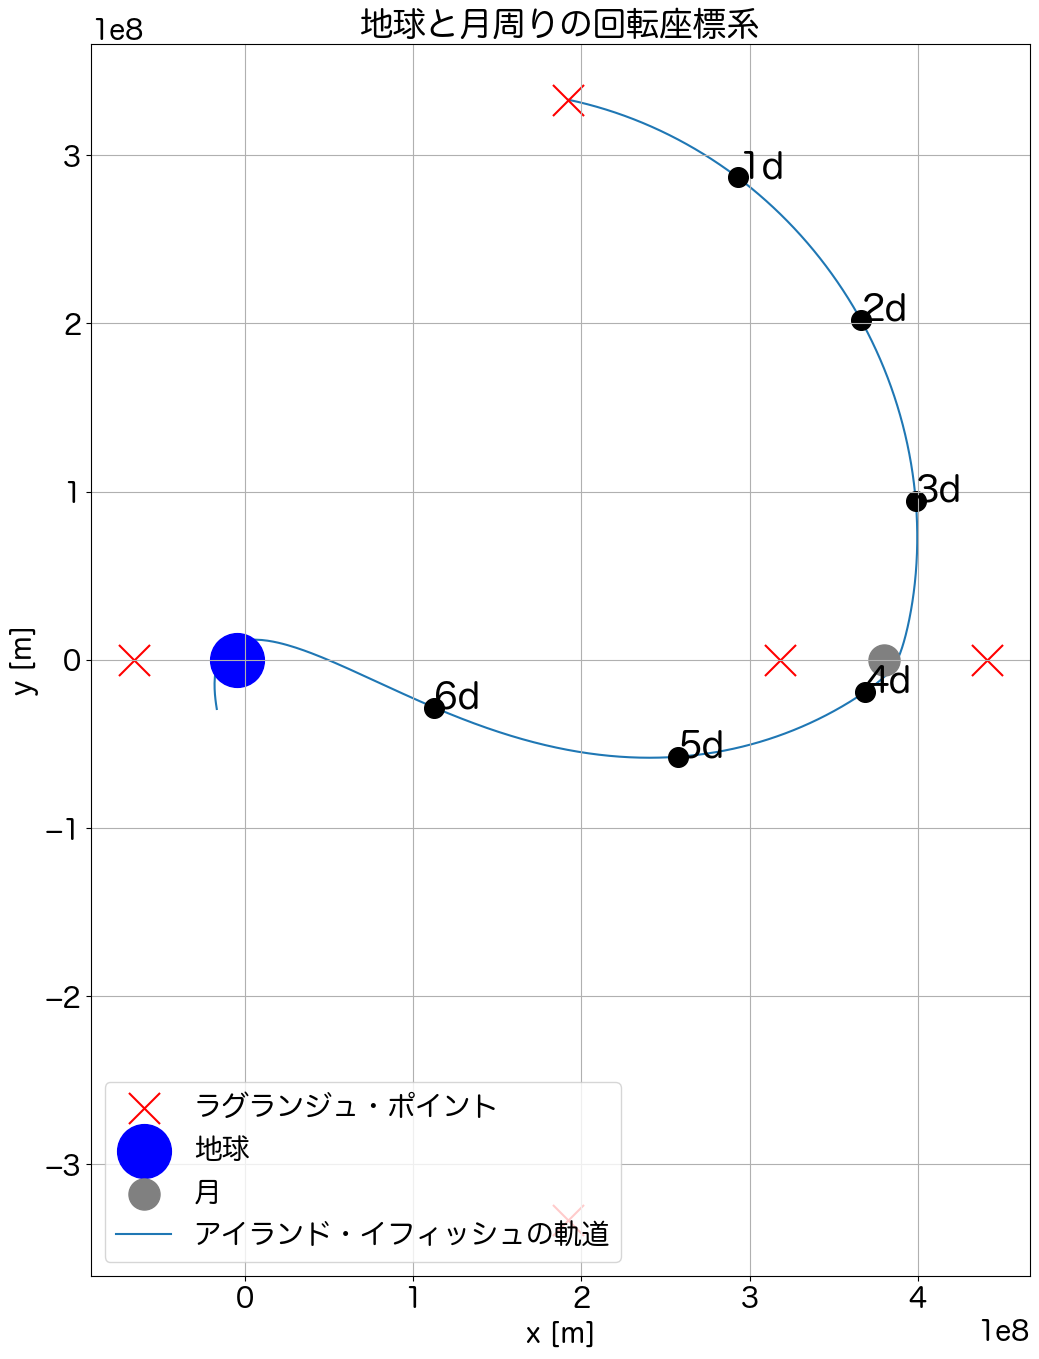

In [6]:
conditions=[ {"pv":[Ls[3][0],Ls[3][1], 1260, -265],   # 1676, -900
              "t":(0, 6.5 * 24 * 3600),"name":"アイランド・イフィッシュの軌道"}]
sols = [{"sol":do_simulation(c["pv"],c["t"]),"name":c["name"]} for c in conditions]
visualize_2d(sols,True)

In [7]:
colony_r=6400/2; omega=2*math.pi/113.5 # 直径6.4kmで113.5秒で1回転するコロニー
def gravity(x, y): # 無重力状態にする
    return [0,0]
def visualize_in_colony(sols,l): # コロニー内表示
    circle=patches.Circle((0,0),colony_r,
      edgecolor='black',facecolor='none',linewidth=1)
    plt.figure();ax=plt.axes();ax.add_patch(circle)
    for sol in sols:
        plt.plot(sol["sol"].y[0],sol["sol"].y[1],linewidth=10)
    plt.xlabel("x [m]");plt.ylabel("y [m]")
    plt.xlim([-l,l]);plt.ylim([-colony_r,-colony_r+2*l])
    plt.gca().set_aspect('equal',adjustable='box');plt.grid();plt.show()

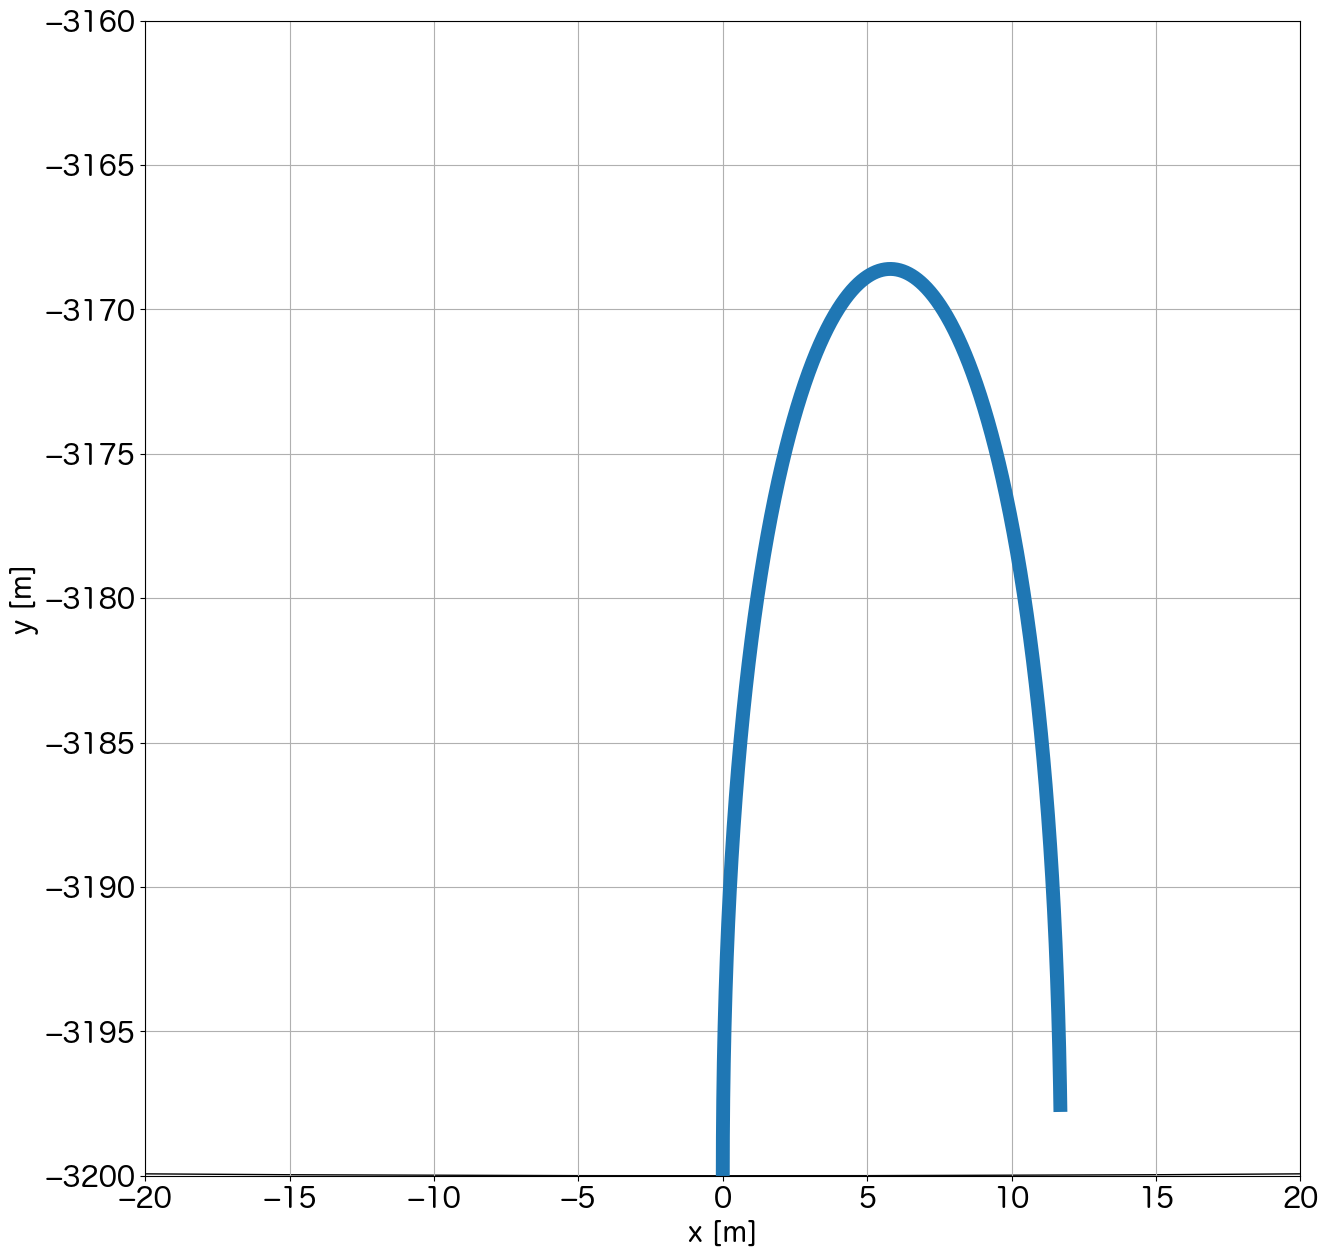

In [8]:
conditions=[{"pv":[0,-colony_r,0,25],
             "t":(0,4.9),"name":"ボールの軌道"}]
visualize_in_colony([{"sol":do_simulation(c["pv"],
  c["t"]),"name":c["name"]} for c in conditions],20)

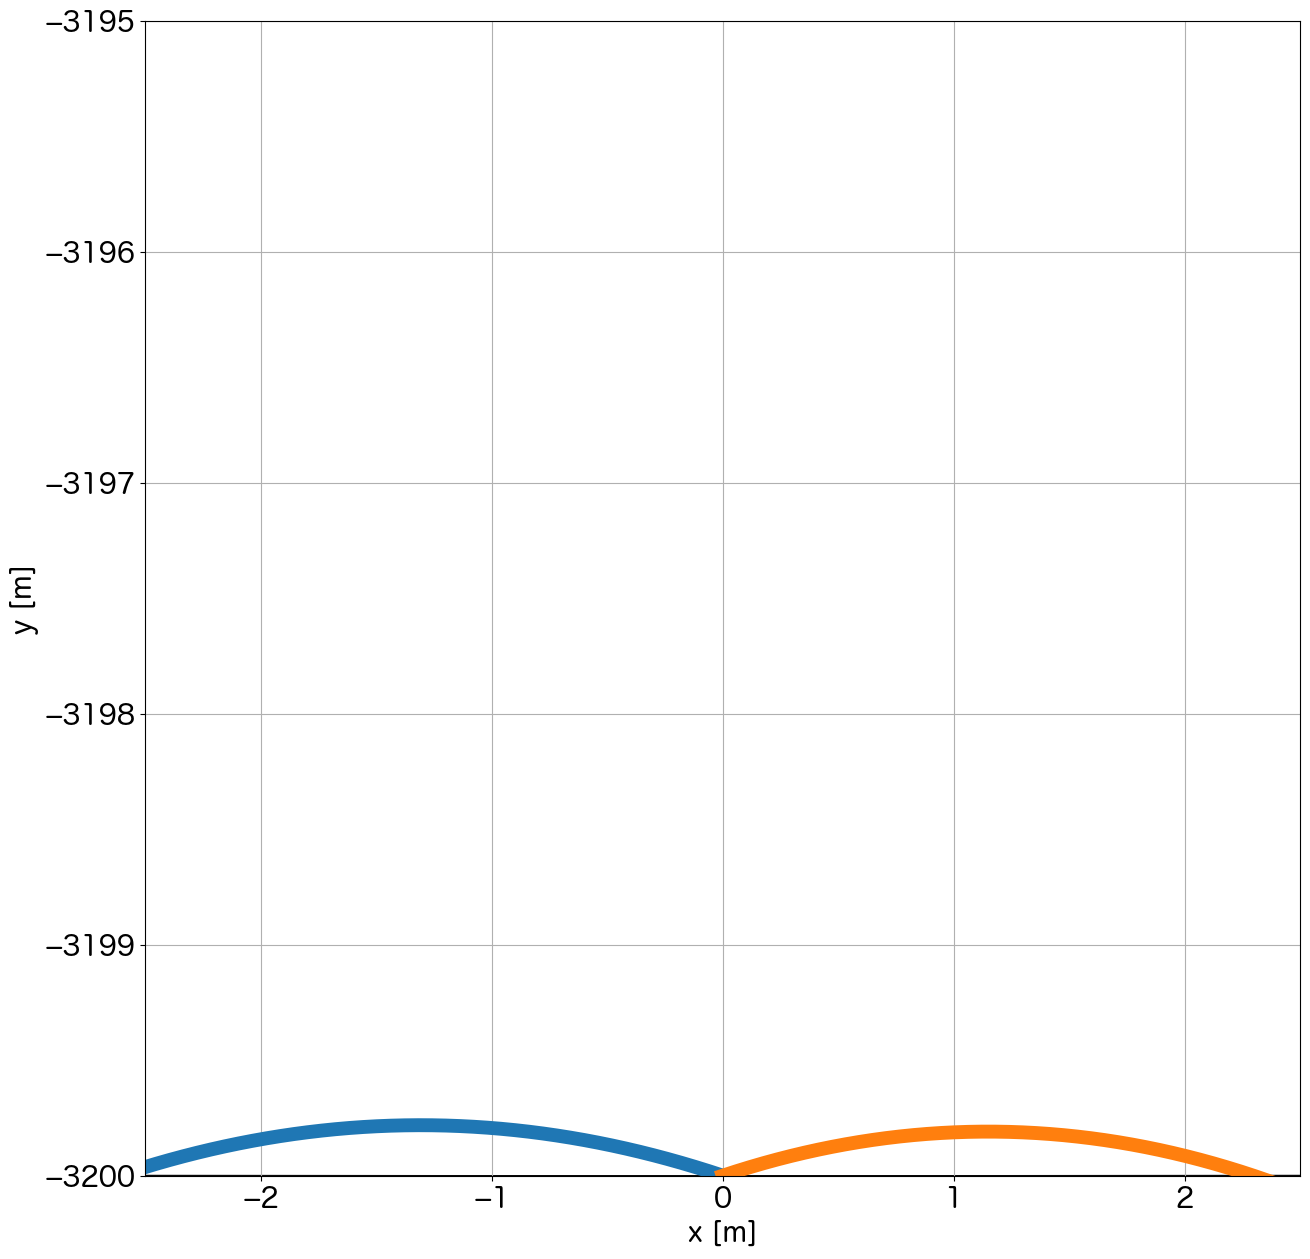

In [9]:
conditions=[{"pv":[0,-colony_r,-6,2],"t":(0,5),"name":"反回転方向"},
{"pv":[0,-colony_r, 6,2], "t":(0, 4.9),"name":"回転方向"}]
visualize_in_colony([{"sol":do_simulation(c["pv"],c["t"]), \
                  "name":c["name"]} for c in conditions],2.5)

## 記事の図貼り付け用（実行の必要はありません）

In [ ]:
import numpy as np; import math
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.patches as patches
G = 6.67430e-11  # 万有引力定数 [m^3/kg/s^2]
M1 = 5.972e24  # 天体1（地球）の質量 [kg]
M2 = 7.342e22  # 天体2（月）の質量 [kg]
D = 3.844e8  # 地球-月の距離 [m]
r1 = -M2*D/(M1+M2)  # 地球の位置 [m]
r2 = M1*D/(M1+M2)   # 月の位置 [m]
omega = np.sqrt(G*(M1+M2)/D**3)  # 地球と月の回転角速度 [rad/s]
Ls=[[r2-D*(M2/(3*M1))**(1/3),0],[r2+D*(M2/(3*M1))**(1/3),0],
    [r1-D*(M2/(3*M1))**(1/3),0],[D/2,np.sqrt(3)*D/2],[D/2,-np.sqrt(3)*D/2]]
def gravity(x, y):
    r1_vec = np.array([r1, 0]) # 天体1位置ベクトル
    r2_vec = np.array([r2, 0]) # 天体2位置ベクトル
    r_obj  = np.array([x, y])  # 物体位置ベクトル
    r_1 = r_obj-r1_vec # 天体1⇒物体ベクトル
    r_2 = r_obj-r2_vec # 天体2⇒物体ベクトル
    g_1 = -G*M1*r_1/np.linalg.norm(r_1)**3
    g_2 = -G*M2*r_2/np.linalg.norm(r_2)**3
    return g_1+g_2 # 天体1と天体2からの重力を合算して返す
def equations(t, state):
    x,y,vx,vy=state; gx,gy=gravity(x,y) # 重力
    cx,cy=omega**2*np.array([x,y])      # 遠心力
    fx,fy=-2*omega*np.array([-vy,vx])   # コリオリ力
    return [vx, vy, gx+cx+fx, gy+cy+fy]
def do_simulation(state0,t_span, n=1000): 
    t_eval = np.linspace(0, t_span[1], n)
    return solve_ivp(equations, t_span, state0, 
                t_eval=t_eval, rtol=1e-9, atol=1e-9)
def visualize_2d(sols,is_plot_day=False):
    plt.figure(figsize=(16, 16))
    plt.scatter([L[0] for L in Ls],[L[1] for L in Ls],c='r',
            marker='x',s=500,label="ラグランジュ・ポイント")
    plt.scatter(r1,0,c='blue',s=1500,label="地球")
    plt.scatter(r2,0,c='gray',s=500,label="月")
    for sol in sols:
        plt.plot(sol["sol"].y[0], sol["sol"].y[1],label=sol["name"],zorder=0)
        if is_plot_day:
            last_t=0; day=1
            for i in range(len(sol["sol"].t)-1):
                if (sol["sol"].t[i]-last_t)>24*60*60:  # 日付表示をする場合
                    plt.text(sol["sol"].y[0, i], sol["sol"].y[1, i],
                        f"{day}d", fontsize=26, color='black')
                    plt.scatter(sol["sol"].y[0,i],sol["sol"].y[1,i],c='black',s=200)
                    last_t=sol["sol"].t[i]; day+=1
    plt.xlabel("x [m]"); plt.ylabel("y [m]"); plt.title("地球と月周りの回転座標系")
    plt.gca().set_aspect('equal',adjustable='box');plt.legend();plt.grid();plt.show()

In [ ]:
conditions=[{"pv":[Ls[i][0],Ls[i][1],0,0],"t":(0,90*24*3600), \
             "name":f"L{i}に置いた物体"} for i in range(5)]
visualize_2d([{"sol":do_simulation(c["pv"],c["t"]),"name":c["name"]} for c in conditions])

In [ ]:
x0_init=0; y0_init=10000*1000 # 地球・月回転中心からL4に向かう向きでL4からの距離 
vx0=(y0_init*2*omega)*(math.sqrt(3)/2)+(-x0_init/2*omega)*1/2 
vy0=(y0_init*2*omega)*(-1/2)+(-x0_init/2*omega)*(math.sqrt(3)/2)
x0 =y0_init*1/2; y0 = y0_init*math.sqrt(3)/2
conditions=[{"pv":[Ls[3][0]+x0,Ls[3][1]+y0,vx0,vy0], 
  "t":(0, 365 * 24 * 3600),"name":"L4周回軌道コロニー"}]
visualize_2d([{"sol":do_simulation(c["pv"],c["t"]),"name":c["name"]} for c in conditions])

In [ ]:
conditions=[{"pv":[Ls[3][0],Ls[3][1], 1260, -265], # Vx, Vy
"t":(0, 6.5 * 24 * 3600),"name":"アイランド・イフィッシュの軌道"}]
visualize_2d([{"sol":do_simulation(c["pv"],c["t"]),"name":c["name"]} \
              for c in conditions],True)

In [136]:
colony_r=6400/2; omega=2*math.pi/113.5 # 直径6.4kmで113.5秒で1回転するコロニー
def gravity(x, y): # 無重力状態にする
    return [0,0]
def visualize_in_colony(sols,l): # コロニー内表示
    circle=patches.Circle((0,0),colony_r,
      edgecolor='black',facecolor='none',linewidth=1)
    plt.figure();ax=plt.axes();ax.add_patch(circle)
    for sol in sols:
        plt.plot(sol["sol"].y[0],sol["sol"].y[1],linewidth=10)
    plt.xlabel("x [m]");plt.ylabel("y [m]")
    plt.xlim([-l,l]);plt.ylim([-colony_r,-colony_r+2*l])
    plt.gca().set_aspect('equal',adjustable='box');plt.grid();plt.show()

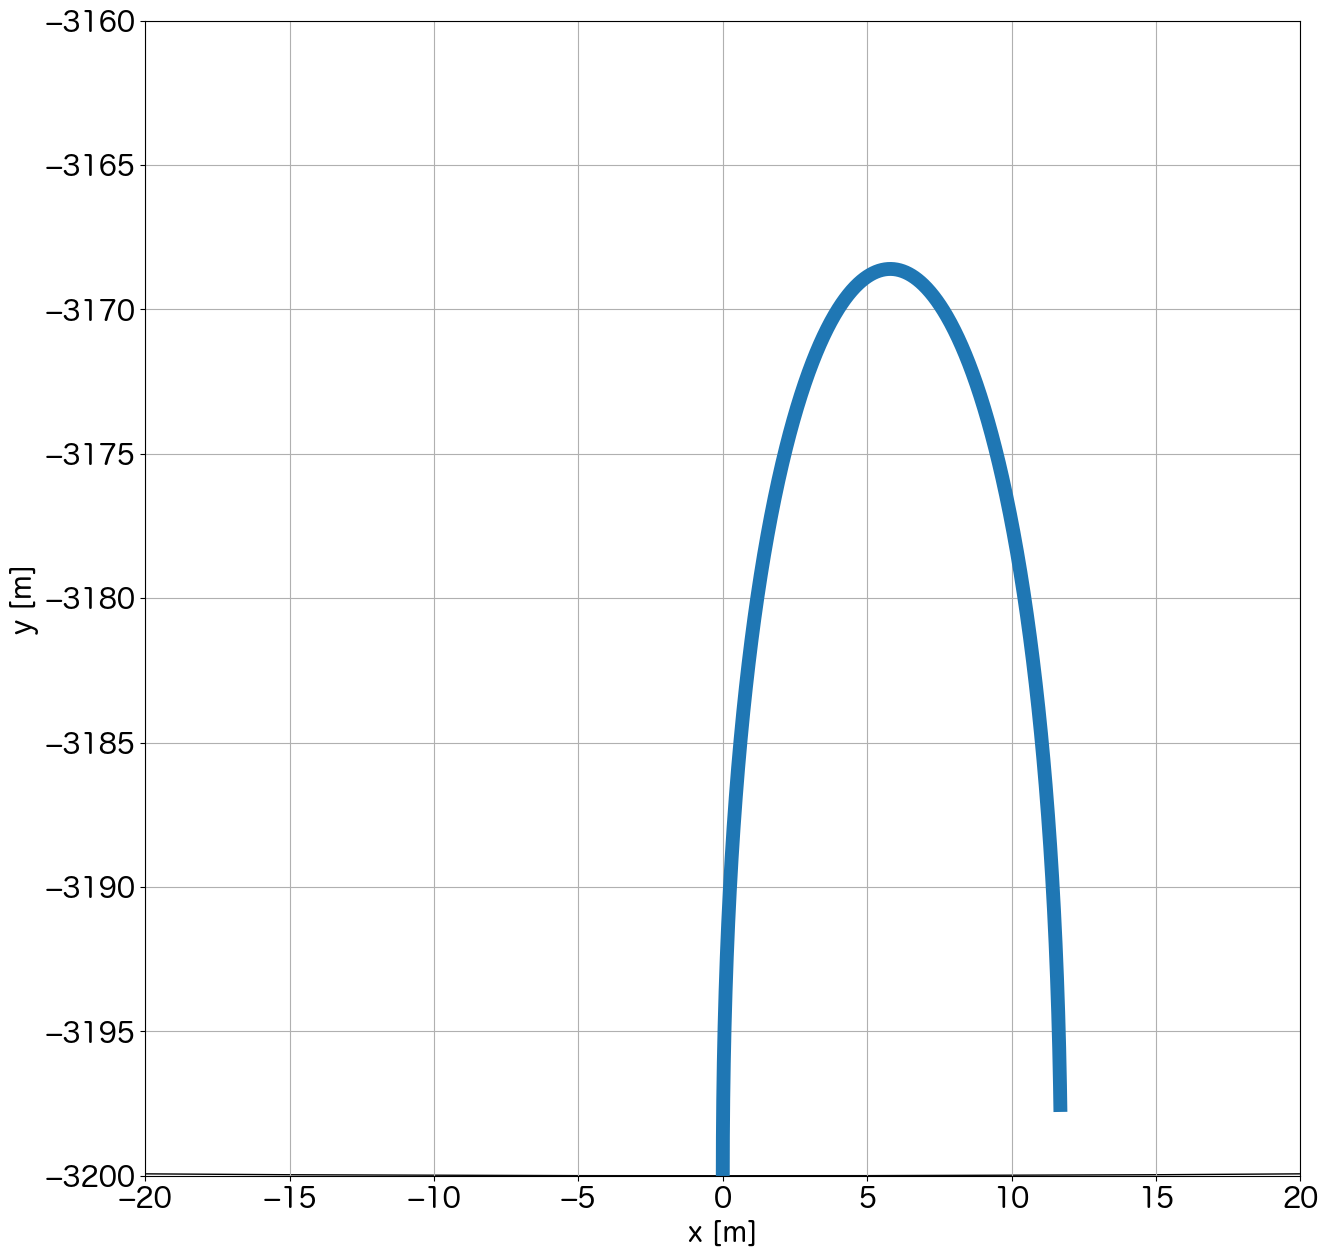

In [137]:
conditions=[{"pv":[0,-colony_r,0,25],
             "t":(0,4.9),"name":"ボールの軌道"}]
visualize_in_colony([{"sol":do_simulation(c["pv"],
  c["t"]),"name":c["name"]} for c in conditions],20)

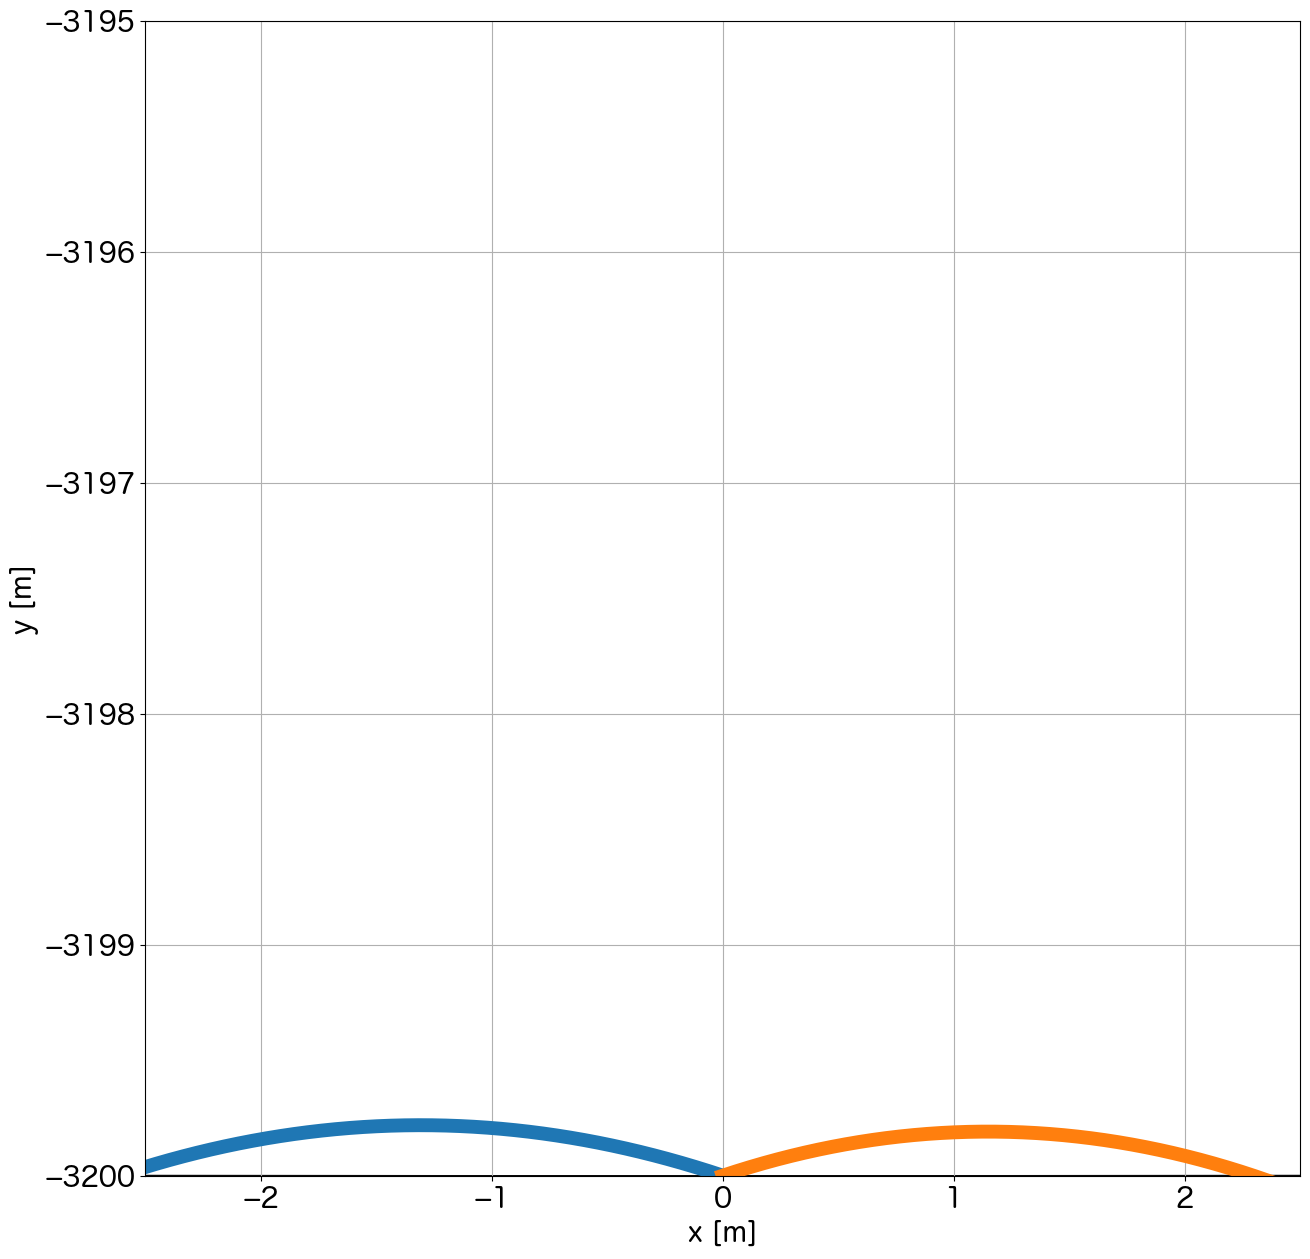

In [138]:
conditions=[{"pv":[0,-colony_r,-6,2],"t":(0,5),"name":"反回転方向"},
{"pv":[0,-colony_r, 6,2], "t":(0, 4.9),"name":"回転方向"}]
visualize_in_colony([{"sol":do_simulation(c["pv"],c["t"]), \
                  "name":c["name"]} for c in conditions],2.5)